In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image as im
import random
%autosave 190

import zipfile as zf
import os
import shutil
from tqdm import tqdm
import cv2
import imutils 
from collections import Counter
import time

Autosaving every 190 seconds


In [2]:
#all library needed for CNN
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization, Input, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras import optimizers,regularizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import VGG19, DenseNet201, DenseNet121
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GroupShuffleSplit

from skimage.transform import resize

from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [3]:
path = r"C:\CSU class\Calss 2022 Spring Local\CS 445\Final Project\Datasets"
train_path = os.path.join(path, "Train")
test_path = os.path.join(path, "Test")

### read image dataset

In [4]:
def crop_brain_contour(image):
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    # determine the most extreme points along the contour
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out using the extreme points
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            
    
    return new_image

In [5]:
xtrain_ori = list()
ytrain_ori = list()
listshape = list()
s = time.time()
for root, dirs, files in os.walk(train_path):
    if not dirs:
        title = root.split("\\")[-1]
        for i in range(len(files)):
            temppath = os.path.join(root, files[i])
            
            ytrain_ori.append(title)
            
#             img = im.open(temppath)
#             img = np.array(img)
            img = cv2.imread(temppath)
            img = crop_brain_contour(img)
#resize function is from library skimage.transform import resize         
            temp = resize(img, (100, 100))
            listshape.append(temp.shape)
            
            xtrain_ori.append(temp)
print("time:", np.round(time.time() - s, 4))

time: 3.2579


In [6]:
Counter(listshape)

Counter({(100, 100, 3): 253})

All the images have saved in the difference sizes

Since the shape of train is imbalance, so we will have to calculate weigth on this datasets

### Now we need to randomize the or shuffe the list to make sure we won't have a mistake from setting incorder

In [7]:
np.array(xtrain_ori).shape

(253, 100, 100, 3)

In [8]:
random.seed(99)
randlis = [i for i in range(len(xtrain_ori))]
random.shuffle(randlis)
random.shuffle(randlis)
random.shuffle(randlis)
random.shuffle(randlis)
random.shuffle(randlis)
random.shuffle(randlis)
xtrain, ytrain = list(), list()
for i in randlis:
    xtrain.append(xtrain_ori[i])
    temp = ytrain_ori[i]
    if temp.lower() == 'no':
        ytrain.append(0)
    else:
        ytrain.append(1)

In [9]:
xtrain = np.array(xtrain) / 255.0
ytrain = to_categorical(np.array(ytrain))

In [10]:
xtrain.shape, ytrain.shape

((253, 100, 100, 3), (253, 2))

### Train test split data

In [11]:
xtrain, xtest, ytrain, ytest = train_test_split(
    np.array(xtrain), np.array(ytrain), test_size=.2 , random_state=11)

### Calculating weight

In [12]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(ytrain_ori),
                                                 ytrain_ori)
class_weights = class_weights[::-1]

C:\Users\singt\anaconda3\envs\tf2\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=['no' 'yes'], y=['no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'ye

### Training model

In [13]:
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,\
     Dropout,Flatten,Dense,Activation,\
     BatchNormalization

model=Sequential()
model.add(Conv2D(32,(3,3),activation='relu',input_shape=(100,100,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Dropout(0.25))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
# model.add(Dropout(0.5))
model.add(Dropout(0.1))
model.add(Dense(2,activation='softmax'))
model.compile(loss='binary_crossentropy',
  optimizer='adam',metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 98, 98, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 47, 47, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 23, 23, 64)        0

In [15]:
es = EarlyStopping(monitor='val_loss')

In [16]:
# history = model.fit(xtrain, ytrain.astype('int'), epochs = 80,
#                     class_weight={0: class_weights[0], 1:class_weights[1]},
#                    callbacks=[es])

In [17]:
data_train = ImageDataGenerator(
    rotation_range= 8,
    zoom_range = 0.1
)
train_gen = data_train.flow(xtrain, ytrain, shuffle = True)

data_test = ImageDataGenerator(
)
vail_gen = data_test.flow(xtest, ytest)

In [18]:
earlystop = EarlyStopping(patience = 10)
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_acc',patience = 2,verbose = 1,factor = 0.5,min_lr = 0.00001)
callbacks = [earlystop,learning_rate_reduction]

In [24]:
# Without weight
history = model.fit(train_gen, epochs = 30,
                    validation_data=vail_gen,
                    validation_steps=xtest.shape[0],
                    steps_per_epoch=xtrain.shape[0],
                    class_weight = {0: class_weights[0], 1:class_weights[1]},
                    callbacks = callbacks
                   )


Epoch 1/30
202/202 [==============================] - 10s 48ms/step - loss: 0.0030 - accuracy: 0.9988 - val_loss: 1.9886 - val_accuracy: 0.7666
Epoch 2/30
202/202 [==============================] - 10s 47ms/step - loss: 0.0079 - accuracy: 0.9979 - val_loss: 1.8751 - val_accuracy: 0.7062
Epoch 3/30
202/202 [==============================] - 10s 48ms/step - loss: 0.0057 - accuracy: 0.9985 - val_loss: 1.9048 - val_accuracy: 0.7452
Epoch 4/30
202/202 [==============================] - 10s 48ms/step - loss: 0.0055 - accuracy: 0.9981 - val_loss: 1.6518 - val_accuracy: 0.7651
Epoch 5/30
202/202 [==============================] - 10s 48ms/step - loss: 0.0040 - accuracy: 0.9990 - val_loss: 9.7554 - val_accuracy: 0.6274
Epoch 6/30
202/202 [==============================] - 10s 49ms/step - loss: 0.0030 - accuracy: 0.9988 - val_loss: 2.9020 - val_accuracy: 0.7643
Epoch 7/30
202/202 [==============================] - 10s 49ms/step - loss: 0.0041 - accuracy: 0.9983 - val_loss: 1.5227 - val_accuracy:

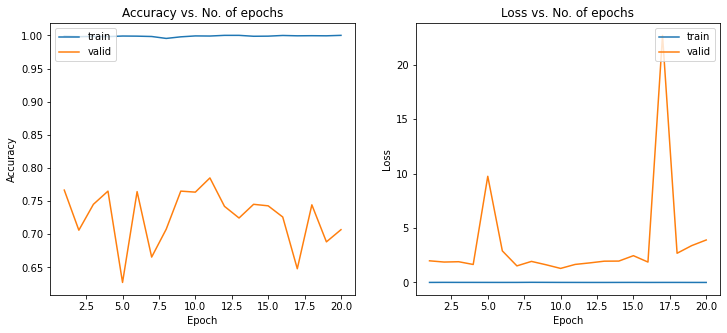

In [26]:
def plot_history(history):    
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc)
    plt.plot(x, val_acc)
    plt.title('Accuracy vs. No. of epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'valid'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(x, loss)
    plt.plot(x, val_loss)
    plt.title('Loss vs. No. of epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'valid'], loc='upper right')
    plt.show()
plot_history(history)

In [22]:
results = model.evaluate(xtrain, ytrain, verbose=0)
print('Test Loss: {:.5f}'.format(results[0]))
print('Test Accuracy: {:.2f}%'.format(results[1] * 100))

Test Loss: 0.04314
Test Accuracy: 99.01%


In [23]:
results = model.evaluate(xtest, ytest, verbose=0)
print('Test Loss: {:.5f}'.format(results[0]))
print('Test Accuracy: {:.2f}%'.format(results[1] * 100))

Test Loss: 3.13042
Test Accuracy: 68.63%


### Save model

In [ ]:
model.save("Brain_Tumor_3rd_attemp_model_2.h5")

In [28]:
model = tf.keras.models.load_model("Brain_Tumor_3rd_attemp_model.h5")

### Prediction with Test datasets

In [29]:
xTEST = list()
TTEST = list()
listshape = list()
s = time.time()
for root, dirs, files in os.walk(test_path):
    if not dirs:
        title = root.split("\\")[-1]
        for i in range(len(files)):
            temppath = os.path.join(root, files[i])
            
            TTEST.append(title)
            img = cv2.imread(temppath)
            img = crop_brain_contour(img)

            temp = resize(img, (100, 100))
            listshape.append(temp.shape)
            
            xTEST.append(temp)
print("time:", np.round(time.time() - s, 4))

time: 4.2976


In [40]:
newT = list()
for i in range(len(TTEST)):
    if TTEST[i].lower() == 'no':
        newT.append(0)
    else:
        newT.append(1)

In [41]:
newT = to_categorical(newT)

In [44]:
test_gen = data_test.flow(np.array(xTEST), newT)

In [45]:
pred = model.evaluate(test_gen)

8/8 [==============================] - 0s 27ms/step - loss: 183.3524 - accuracy: 0.6996


In [46]:
np.array(xTEST).shape, np.array(TTEST).shape

((253, 100, 100, 3), (253,))